# This notebook will load a checkpoint with no speaker_embeddings, and reshape the conditioning layer to use the speaker_embedding layer as input BUT keep the original weights for the spectrogram inputs.
Basically adding speaker embeddings without resetting/removing anything from the network.

In [1]:
import argparse
import json
import os
import torch
import os.path
import sys
import time
from math import ceil, e, exp
import math

import numpy as np
import soundfile as sf

# Load (source) config file

In [2]:
config_fpath = r"H:\TTCheckpoints\waveglow\outdir_EfficientLarge3\config.json"

# Parse configs.  Globals nicer in this case
with open(config_fpath) as f:
    data = f.read()
config = json.loads(data)
train_config = config["train_config"]
global data_config
data_config = config["data_config"]
global dist_config
dist_config = config["dist_config"]
global waveglow_config
waveglow_config = {
    **config["waveglow_config"], 
    'win_length': data_config['win_length'],
    'hop_length': data_config['hop_length']
}
print(str(waveglow_config).replace(",",",\n"))

{'yoyo': True,
 'yoyo_WN': False,
 'n_mel_channels': 160,
 'n_flows': 48,
 'n_group': 24,
 'n_early_every': 8,
 'n_early_size': 2,
 'memory_efficient': True,
 'spect_scaling': False,
 'upsample_mode': 'normal',
 'WN_config': {'n_layers': 8,
 'n_channels': 256,
 'kernel_size': 3,
 'speaker_embed_dim': 0,
 'rezero': False},
 'win_length': 2400,
 'hop_length': 600}


# Initialize blank model

In [3]:
if waveglow_config["yoyo"]: # efficient_mode # TODO: Add to Config File
    from efficient_model import WaveGlow
    from efficient_loss import WaveGlowLoss
else:
    from glow import WaveGlow, WaveGlowLoss
model = WaveGlow(**waveglow_config).cuda()

# Load Checkpoint

In [1]:
checkpoint_path = r"H:\TTCheckpoints\waveglow\outdir_EfficientLarge3\waveglow_90065"

assert os.path.isfile(checkpoint_path)
checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
model_dict = checkpoint_dict['model']
if (str(type(model_dict)) != "<class 'collections.OrderedDict'>"):
    model_dict = model_dict.state_dict()
model_dict = {k.replace("invconv1x1","convinv").replace(".F.",".WN.").replace("WNs.","WN."): v for k, v in model_dict.items()}
model.load_state_dict(model_dict)

#model = model.cuda()

NameError: name 'os' is not defined

# Set new speaker_embed_dim target

In [5]:
waveglow_config['WN_config']['speaker_embed_dim'] = 96

Summary of first Cond Layer weights

In [6]:
model.WN[0].WN.cond_layer.weight.shape
#weight – filters of shape (out_channels, in_channels/groups, kernel_width)

# (2*n_channels*n_layers, n_mel_channels, kernel_width)
# (4096                 ,256            , 1           )

torch.Size([4096, 160, 1])

for each cond_layer in WaveGlow, reshape the weights, keeping the pretrained weights for spectrogram inputs, but using randomly initilized weights for the speaker embedding inputs.

In [8]:
# get target speaker_embed_dim (feel free to override if your config file isn't your target model)
speaker_embed_dim = waveglow_config['WN_config']['speaker_embed_dim']
print("speaker_embed_dim =", speaker_embed_dim)
n_mel_channels = waveglow_config['n_mel_channels']
print("n_mel_channels =", n_mel_channels)

speaker_embed_dim = 96
n_mel_channels = 160


In [9]:
x = torch.rand(5,5,1) # original trained weights
print("x.shape =", x.shape)
y = torch.rand(5,2,1) # new blank weights
print("y.shape =", y.shape)
z = torch.cat((x, y), dim=1)
print("z.shape =", z.shape)
print("top of x =", x[0,:,:].view(-1))
print("top of y =", y[0,:,:].view(-1))
print("top of z =", z[0,:,:].view(-1))
print("therefore, x gets stacked above y. (hope that's the correct order, find out soon)")

x.shape = torch.Size([5, 5, 1])
y.shape = torch.Size([5, 2, 1])
z.shape = torch.Size([5, 7, 1])
top of x = tensor([0.8866, 0.5631, 0.9490, 0.5928, 0.8621])
top of y = tensor([0.0332, 0.5340])
top of z = tensor([0.8866, 0.5631, 0.9490, 0.5928, 0.8621, 0.0332, 0.5340])
therefore, x gets stacked above y. (hope that's the correct order, find out soon)


In [10]:
# cond_layer.weight
for index, cond_layer in enumerate([model.WN[i].WN.cond_layer for i in range(len(model.WN))]):
    model.WN[index].WN.cond_layer = torch.nn.utils.remove_weight_norm(cond_layer) # remove weight norm
    cond_layer = model.WN[index].WN.cond_layer
    
    cond_weights = cond_layer.weight
    outsize, in_size, kernel_width = cond_layer.weight.shape
    #print("cond_layer.weight.shape =", cond_layer.weight.shape)
    
    new_in_size = n_mel_channels+speaker_embed_dim
    new_weights = torch.normal(0, 0.1, size=(outsize, new_in_size-in_size, kernel_width), device=cond_layer.weight.device)
                            #(mean, std, size=(...))
    
    new_cond_weights = torch.cat((cond_weights, new_weights), dim=1)
    #print("new_cond_weights.shape =", new_cond_weights.shape)
    
    cond_layer.weight = torch.nn.Parameter(new_cond_weights) # set new weights
    model.WN[index].WN.cond_layer = torch.nn.utils.weight_norm(cond_layer, name='weight') # re-add weight norm

cond_layer.weight.shape = torch.Size([4096, 160, 1])
new_cond_weights.shape = torch.Size([4096, 256, 1])
cond_layer.weight.shape = torch.Size([4096, 160, 1])
new_cond_weights.shape = torch.Size([4096, 256, 1])
cond_layer.weight.shape = torch.Size([4096, 160, 1])
new_cond_weights.shape = torch.Size([4096, 256, 1])
cond_layer.weight.shape = torch.Size([4096, 160, 1])
new_cond_weights.shape = torch.Size([4096, 256, 1])
cond_layer.weight.shape = torch.Size([4096, 160, 1])
new_cond_weights.shape = torch.Size([4096, 256, 1])
cond_layer.weight.shape = torch.Size([4096, 160, 1])
new_cond_weights.shape = torch.Size([4096, 256, 1])
cond_layer.weight.shape = torch.Size([4096, 160, 1])
new_cond_weights.shape = torch.Size([4096, 256, 1])
cond_layer.weight.shape = torch.Size([4096, 160, 1])
new_cond_weights.shape = torch.Size([4096, 256, 1])
cond_layer.weight.shape = torch.Size([4096, 160, 1])
new_cond_weights.shape = torch.Size([4096, 256, 1])
cond_layer.weight.shape = torch.Size([4096, 160, 1])
ne

# Save new model

In [11]:
save_fpath = "H:\TTCheckpoints\waveglow\outdir_EfficientLarge3\waveglow_90065_speaker_embeds"

checkpoint_dict['model'] = model.state_dict()
if 'optimizer' in checkpoint_dict.keys():
    del checkpoint_dict['optimizer'] # optimizer will be wrong shape.
torch.save(checkpoint_dict, save_fpath)
print("Model Saved")

Model Saved


# Other Stuffs

In [175]:
audio = torch.rand(5,1,6000)
spect = torch.rand(5,160,6000)
n_group = 8

if audio is not None:  # during synthesize phase, we feed audio as None
    # squeeze 1D waveform audio into 2d matrix given height self.n_group
    B, C, T = audio.size()
    assert T % n_group == 0, "cannot make 2D matrix of size {} given self.n_group={}".format(T, self.n_group)
    print("audio.shape =", audio.shape)
    audio = audio.view(B, int(T / n_group), C * n_group)
    print("audio.shape =", audio.shape)
    # permute to make column-major 2D matrix of waveform
    audio = audio.permute(0, 2, 1)
    print("audio.shape =", audio.shape)
    # unsqueeze to have tensor shape of [B, 1, H, W]
    print("audio.shape =", audio.shape)
    audio = audio.unsqueeze(1)
    print("audio.shape =", audio.shape)

# same goes to mel, but keeping the 2D mel-spec shape
B, C, T = spect.size()
print("spect.shape =", spect.shape)
spect = spect.view(B, C, int(T / n_group), n_group)
print("spect.shape =", spect.shape)
spect = spect.permute(0, 1, 3, 2)
print("spect.shape =", spect.shape)

audio.shape = torch.Size([5, 1, 6000])
audio.shape = torch.Size([5, 750, 8])
audio.shape = torch.Size([5, 8, 750])
audio.shape = torch.Size([5, 8, 750])
audio.shape = torch.Size([5, 1, 8, 750])
spect.shape = torch.Size([5, 160, 6000])
spect.shape = torch.Size([5, 160, 750, 8])
spect.shape = torch.Size([5, 160, 8, 750])


In [176]:
import time

In [183]:
x = time

In [180]:
from time import sleep
x = sleep

In [184]:
x

<module 'time' (built-in)>

In [182]:
x(5)

In [185]:
import glob

In [190]:
spect = torch.rand(8, 160, 24000)
x = torch.cuda.FloatTensor(spect.size(0),
                               8,
                               spect.size(2)).normal_()
print(x.shape)
print(x.mean())
print(x.std())

torch.Size([8, 8, 24000])
tensor(-0.0005, device='cuda:0')
tensor(1.0002, device='cuda:0')


In [206]:
spect = torch.rand(8, 160, 24000).cuda().half()
x = torch.ones(spect.size(0), 8, spect.size(2), device=spect.device, dtype=spect.dtype).normal_(std=0.1)
print(x.shape)
print(x.mean())
print(x.std())

torch.Size([8, 8, 24000])
tensor(-6.1452e-05, device='cuda:0', dtype=torch.float16)
tensor(0.1000, device='cuda:0', dtype=torch.float16)


In [262]:
x = torch.rand(5,5).cuda().half()

In [263]:
x.type()

'torch.cuda.HalfTensor'

In [264]:
x.dtype

torch.float16

In [265]:
x.device.type

'cuda'

In [202]:
y = torch.rand(1)
y.device

device(type='cpu')

In [212]:
x.view(1,*x.shape,1).shape

torch.Size([1, 8, 8, 24000, 1])

In [227]:
x = torch.rand(8,1,24,750)
print("x.shape =", x.shape)
reverse=False; bipart=False; shift=False; inverse_shift=False
x = torch.split(x, 1, dim=2)
if bipart and reverse:
    half = len(x)//2
    x = x[:half][::-1] + x[half:][::-1] # reverse H halfs [0,1,2,3,4,5,6,7] -> [3,2,1,0] + [7,6,5,4] -> [3,2,1,0,7,6,5,4]
elif reverse:
    x = x[::-1] # reverse entire H [0,1,2,3,4,5,6,7] -> [7,6,5,4,3,2,1,0]
if shift:
    x = (x[-1],) + x[:-1] # shift last H into first position [0,1,2,3,4,5,6,7] -> [7,0,1,2,3,4,5,6]
elif inverse_shift:
    x = x[1:] + (x[0],)   # shift first H into last position [0,1,2,3,4,5,6,7] -> [1,2,3,4,5,6,7,0]
x = torch.stack(x, dim=2)
print("x.shape =", x.shape)

x.shape = torch.Size([8, 1, 24, 750])
x.shape = torch.Size([8, 1, 24, 1, 750])


In [239]:
x = torch.rand(8,1,24,750)
print(x.shape)
x = [x[:,:,i] for i in range(x.shape[-2])]
print(len(x))
x = torch.stack(x, dim=2)
print(x.shape)

torch.Size([8, 1, 24, 750])
24
torch.Size([8, 1, 24, 750])


In [246]:
torch.rand(5,5,2,2,2,2,2,2).sum()

tensor(810.1740)

In [247]:
import numpy as np
0.5 * np.log(2 * np.pi) + np.log(1.0)

0.9189385332046727

In [432]:
import torch
import torch.nn as nn


class UpsampleRNN(nn.Module):
    def __init__(self, numhidden):
        super(UpsampleRNN, self).__init__()
        self.num_hidden = numhidden

        self.rnn_x = nn.LSTM(
            input_size=self.num_hidden,
            hidden_size=self.num_hidden,
            batch_first=True,
            bidirectional=True
        )
        self.rnn_y = nn.LSTM(
            input_size=self.num_hidden,
            hidden_size=self.num_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.W = nn.Linear(4 * self.num_hidden, self.num_hidden)

    def flatten_parameters(self):
        self.rnn_x.flatten_parameters()
        self.rnn_y.flatten_parameters()

    def forward(self, inp, audio_lengths):
        self.flatten_parameters()
        
        B, M, T, D = inp.size()
        
        inp_temp = inp.view(-1, T, D) # [B, M, T, D] -> [B*M, T, D]
        inp_temp = nn.utils.rnn.pack_padded_sequence(
            inp_temp,
            audio_lengths.unsqueeze(1).repeat(1, M).reshape(-1),
            batch_first=True,
            enforce_sorted=False
        )
        x, _ = self.rnn_x(inp_temp) # [B*M, T, D] -> [B*M, T, 2*D]
        x, _ = nn.utils.rnn.pad_packed_sequence(
            x,
            batch_first=True,
            total_length=T
        )
        x = x.view(B, M, T, 2 * D)# [B*M, T, 2*D]
        
        y, _ = self.rnn_y(inp.transpose(1, 2).contiguous().view(-1, M, D))
        y = y.view(B, T, M, 2 * D).transpose(1, 2).contiguous()

        z = torch.cat([x, y], dim=-1)

        output = inp + self.W(z)

        return output

In [433]:
upsampler = UpsampleRNN(8)

In [434]:
                 # B=batch, M=mel, T=time, D=hidden
                  #B, M, T, D = inp.size()
spect = torch.rand(8, 80, 640, 8)
print(" spect.shape =", spect.shape)
lengths = torch.tensor([640]).repeat(8)
output = upsampler(spect, lengths)
print("output.shape =", output.shape)

 spect.shape = torch.Size([8, 80, 640, 8])
output.shape = torch.Size([8, 80, 640, 8])


# Tier 2~X

In [435]:
def sample_gmm(mu, std, pi):
    std = std.exp()
    pi = pi.softmax(dim=-1)
    indices = get_pi_indices(pi)
    mu = mu.reshape(-1, mu.shape[-1])
    mu = mu[np.arange(mu.shape[0]), indices].reshape(std.shape[:-1])
    std = std.reshape(-1, std.shape[-1])
    std = std[np.arange(std.shape[0]), indices].reshape(mu.shape)
    return torch.normal(mu, std).reshape_as(mu).clamp(0.0, 1.0).to(mu.device)

In [292]:
class Tier(nn.Module):
    def __init__(self, hp, freq, layers, tierN):
        super(Tier, self).__init__()
        num_hidden = hp.model.hidden
        self.hp = hp
        self.tierN = tierN

        self.W_t = nn.Linear(1, num_hidden)
        self.layers = nn.ModuleList([UpsampleRNN(hp) for _ in range(layers)])
        
        # Gaussian Mixture Model: eq. (2)
        self.K = hp.model.gmm
        self.pi_softmax = nn.Softmax(dim=3)
        
        # map output to produce GMM parameter eq. (10)
        self.W_theta = nn.Linear(num_hidden, 3*self.K)
        
    def forward(self, x, audio_lengths):
        # x: [B, M, T] / B=batch, M=mel, T=time
        h_f = self.W_t(x.unsqueeze(-1))
        for layer in self.layers:
            h_f = layer(h_f, audio_lengths)
        
        theta_hat = self.W_theta(h_f)
        
        mu = theta_hat[..., :self.K] # eq. (3)
        std = theta_hat[..., self.K:2*self.K]
        pi = theta_hat[..., 2*self.K:]

        return mu, std, pi

In [295]:
def interleave(x, y, tier):
    '''
        implements eq. (25)
        x: x^{<g}
        y: x^{g}
        tier: g+1
    '''
    assert x.size() == y.size(), \
        'two inputs for interleave should be identical: got %s, %s' % (x.size(), y.size())

    B, M, T = x.size()
    if tier % 2 == 0:
        temp = x.new_zeros(B, M, 2 * T)
        temp[:, :, 0::2] = x
        temp[:, :, 1::2] = y
    else:
        temp = x.new_zeros(B, 2 * M, T)
        temp[:, 0::2, :] = x
        temp[:, 1::2, :] = y

    return temp

In [299]:
x = torch.rand(8, 80, 750)
print("x.shape =", x.shape)

y = torch.rand(8, 80, 750)
print("y.shape =", y.shape)

tier = 1
z = interleave(x, y, tier)

print("z.shape =", z.shape)
print(z[0,:,0])
print(x[0,:,0])

x.shape = torch.Size([8, 80, 750])
y.shape = torch.Size([8, 80, 750])
z.shape = torch.Size([8, 160, 750])
tensor([0.9434, 0.1923, 0.0090, 0.0320, 0.2719, 0.7531, 0.4704, 0.7462, 0.4647,
        0.9067, 0.8774, 0.3428, 0.2817, 0.8431, 0.9981, 0.8986, 0.2092, 0.6738,
        0.8449, 0.6694, 0.9178, 0.1325, 0.4758, 0.2103, 0.3813, 0.2110, 0.2189,
        0.5432, 0.2700, 0.3561, 0.5547, 0.8461, 0.7066, 0.2214, 0.2900, 0.3323,
        0.4879, 0.5800, 0.2546, 0.1714, 0.4529, 0.6271, 0.5560, 0.6069, 0.8195,
        0.3993, 0.9701, 0.7294, 0.4374, 0.1354, 0.4622, 0.4592, 0.9112, 0.3907,
        0.7817, 0.6251, 0.5439, 0.2600, 0.9527, 0.2195, 0.2069, 0.3905, 0.5778,
        0.1746, 0.1066, 0.8182, 0.4137, 0.8731, 0.0093, 0.7730, 0.1319, 0.2278,
        0.3880, 0.9402, 0.3901, 0.1620, 0.1440, 0.2110, 0.8466, 0.4764, 0.9223,
        0.5651, 0.5281, 0.9631, 0.3007, 0.1499, 0.6332, 0.5627, 0.9373, 0.8098,
        0.8185, 0.6003, 0.3795, 0.2499, 0.0409, 0.5318, 0.8043, 0.3063, 0.9396,
        0.9455

# Packaged Spectrogram Height Upsampler

In [1]:
import torch
import torch.nn as nn
import numpy as np


class UpsampleRNN(nn.Module):
    def __init__(self, numhidden, n_speakers, s_embed_dim):
        super(UpsampleRNN, self).__init__()
        self.num_hidden = numhidden

        self.rnn_x = nn.LSTM(
            input_size=self.num_hidden,
            hidden_size=self.num_hidden,
            batch_first=True,
            bidirectional=True
        )
        self.rnn_y = nn.LSTM(
            input_size=self.num_hidden+s_embed_dim,
            hidden_size=self.num_hidden,
            batch_first=True,
            bidirectional=True
        )
        
        self.embed = nn.Embedding(n_speakers, s_embed_dim)
        
        self.W = nn.Linear(4 * self.num_hidden, self.num_hidden)

    def flatten_parameters(self):
        self.rnn_x.flatten_parameters()
        self.rnn_y.flatten_parameters()

    def forward(self, inp, speaker_id, audio_lengths):
        self.flatten_parameters()
        
        B, M, T, D = inp.size()
        
        inp_temp = inp.view(-1, T, D) # [B, M, T, D] -> [B*M, T, D]
        inp_temp = nn.utils.rnn.pack_padded_sequence(
            inp_temp,
            audio_lengths.unsqueeze(1).repeat(1, M).reshape(-1),
            batch_first=True,
            enforce_sorted=False
        )
        x, _ = self.rnn_x(inp_temp) # [B*M, T, D] -> [B*M, T, 2*D]
        x, _ = nn.utils.rnn.pad_packed_sequence(
            x,
            batch_first=True,
            total_length=T
        )
        x = x.view(B, M, T, 2 * D) # [B*M, T, 2*D] -> [B, M, T, 2*D]
        
        embedding = self.embed(speaker_id) # [B, embed]
        embedding = embedding.view(embedding.shape[0],1,1,embedding.shape[1]).repeat(1,inp.shape[1],inp.shape[2],1) # [B, embed] -> [B, 1, 1, embed] -> [B, n_mels, T, embed]
        #inp = torch.cat((inp, embedding), dim=3)# [B, n_mels, T, embed] + [B, n_mels, T, hidden] -> [B, n_mels, T, embed+hidden]
        
        y, _ = self.rnn_y(torch.cat((inp, embedding), dim=3).transpose(1, 2).contiguous().view(-1, M, inp.shape[-1]+embedding.shape[-1]))# [B, M, T, D] -> [B, T, M, D] -> [B*T, M, D]
        y = y.view(B, T, M, 2 * D).transpose(1, 2).contiguous()# [B*T, M, 2*D] -> [B, T, M, 2*D] -> [B, M, T, 2*D]
        
        z = torch.cat([x, y], dim=-1)# [B, M, T, 2*D] + [B, M, T, 2*D] -> [B, M, T, 4*D]
        z = self.W(z)# [B, M, T, 4*D] -> [B, M, T, D]
        
        output = inp + z# [B, M, T, D] + [B, M, T, D] -> [B, M, T, D]

        return output


def get_pi_indices(pi):
    cumsum = torch.cumsum(pi.cpu(), dim=-1)
    rand = torch.rand(pi.shape[:-1] + (1,))
    indices = (cumsum < rand).sum(dim=-1)
    return indices.flatten().detach().numpy()


def sample_gmm(mu, std, pi):
    std = std.exp()
    pi = pi.softmax(dim=-1)
    indices = get_pi_indices(pi)
    mu = mu.reshape(-1, mu.shape[-1])
    mu = mu[np.arange(mu.shape[0]), indices].reshape(std.shape[:-1])
    std = std.reshape(-1, std.shape[-1])
    std = std[np.arange(std.shape[0]), indices].reshape(mu.shape)
    return torch.normal(mu, std).reshape_as(mu).clamp(0.0, 1.0).to(mu.device)


def interleave(x, y, dim):
    '''
        implements eq. (25)
        x: x^{<g}
        y: x^{g}
        tier: g+1
    '''
    assert x.size() == y.size(), \
        'two inputs for interleave should be identical: got %s, %s' % (x.size(), y.size())

    B, M, T = x.size()
    if dim==2:
        temp = x.new_zeros(B, M, 2 * T)
        temp[:, :, 0::2] = x
        temp[:, :, 1::2] = y
    elif dim==1:
        temp = x.new_zeros(B, 2 * M, T)
        temp[:, 0::2, :] = x
        temp[:, 1::2, :] = y
    else:
        raise NotImplementedError

    return temp


class Tier(nn.Module):
    """
    Upsamples a spectrogram along n_mel_channel dimensions.
    """
    def __init__(self, hidden_dim, gmm_mixtures, layers, n_speakers, s_embed_dim):
        super(Tier, self).__init__()
        
        self.W_t = nn.Linear(1, hidden_dim)
        self.layers = nn.ModuleList([UpsampleRNN(hidden_dim, n_speakers, s_embed_dim) for _ in range(layers)])
        
        # Gaussian Mixture Model: eq. (2)
        self.K = gmm_mixtures
        self.pi_softmax = nn.Softmax(dim=3)
        
        # map output to produce GMM parameter eq. (10)
        self.W_theta = nn.Linear(hidden_dim, 3*self.K)
    
    def forward(self, x, speaker_id, audio_lengths):
        # x: [B, M, T] / B=batch, M=mel, T=time
        h_f = self.W_t(x.unsqueeze(-1)) #[B, mel, T]
        for layer in self.layers:
            h_f = layer(h_f, speaker_id, audio_lengths)
        
        theta_hat = self.W_theta(h_f)
        
        mu = theta_hat[..., :self.K] # eq. (3)
        std = theta_hat[..., self.K:2*self.K]
        pi = theta_hat[..., 2*self.K:]
        
        h_f = sample_gmm(mu, std, pi)
        
        x = interleave(x, h_f, 1)
        
        return x

In [2]:

upsampler = Tier(32, 1, 1, 512, 96).cuda()
#optimizer = torch.optim.Adam(upsampler.parameters(), lr=1e-1)

In [32]:
                 # B=batch, M=mel, T=time, D=hidden
                  #B, M, T, D = inp.size()
spect = torch.rand(8, 160, 40, device="cuda")
print(" spect.shape =", spect.shape)
lengths = torch.tensor([40], device="cuda").repeat(8)
speaker_ids = torch.ones(8, device="cuda").long()

output = upsampler(spect, speaker_ids, lengths)
print("output.shape =", output.shape)
output = output.mean()
print(output)
output.backward()
upsampler.zero_grad()

 spect.shape = torch.Size([8, 160, 40])
output.shape = torch.Size([8, 320, 40])
tensor(0.4334, device='cuda:0', grad_fn=<MeanBackward0>)


In [3]:
%%timeit
with torch.no_grad():
    spect = torch.rand(8, 160, 40, dtype=torch.float32, device="cuda")
    lengths = torch.tensor([40], dtype=torch.float32, device="cuda").repeat(8)
    speaker_ids = torch.ones(8, dtype=torch.float32, device="cuda").long()
    output = upsampler(spect, speaker_ids, lengths)

90.1 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [400]:
spect = torch.rand(8, 160, 40, device="cuda")
lengths = torch.tensor([40], device="cuda").repeat(8)
output = upsampler(spect, lengths)
output = upsampler(output, lengths)
print(output.shape)

torch.Size([8, 640, 40])


# Speaker Embedded Autoencoder

In [4]:
torch.rand(1).half().dtype

torch.float16

In [9]:
for i in upsampler.parameters():
    print(i.dtype)
    break

torch.float32


In [11]:
(torch.ones(2,2)*2)

tensor([[2., 2.],
        [2., 2.]])

In [12]:
(torch.ones(2,2)*2) * (torch.ones(2,2)*2)

tensor([[4., 4.],
        [4., 4.]])

In [13]:
(torch.ones(2,2)*2) @ (torch.ones(2,2)*2)

tensor([[8., 8.],
        [8., 8.]])

In [15]:
x = torch.rand(5)

In [16]:
x

tensor([0.4528, 0.4420, 0.4904, 0.3633, 0.6293])

In [17]:
x.requires_grad

False

In [20]:
x = torch.arange(10)
print(x)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [22]:
x.flip(0).view(-1)

tensor([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [30]:
                #   [B, n_mel, n_group, T//n_group]
x = torch.arange(750)[None, None, None, ...].repeat(8, 160, 8, 1) # init as mel-spec example
print("x.shape =", x.shape)
x = x.permute((0, 3, 1, 2)).contiguous().view(-1, *x.shape[-2:]) # [B, n_mel, n_group, T//n_group] -> [B, T//n_group, n_mel, n_group] -> [B*T//n_group, n_mel, n_group]
print("x.shape =", x.shape)
print(x)

x.shape = torch.Size([8, 160, 8, 750])
x.shape = torch.Size([1280, 8, 750])
tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         ...,
         [  2,   2,   2,  ...,   3,   3,   3],
         [  3,   3,   3,  ...,   4,   4,   4],
         [  4,   4,   4,  ...,   4,   4,   4]],

        [[  4,   4,   4,  ...,   5,   5,   5],
         [  5,   5,   5,  ...,   5,   5,   5],
         [  5,   5,   5,  ...,   6,   6,   6],
         ...,
         [  7,   7,   7,  ...,   8,   8,   8],
         [  8,   8,   8,  ...,   8,   8,   8],
         [  8,   8,   8,  ...,   9,   9,   9]],

        [[  9,   9,   9,  ...,   9,   9,   9],
         [  9,   9,   9,  ...,  10,  10,  10],
         [ 10,  10,  10,  ...,  11,  11,  11],
         ...,
         [ 12,  12,  12,  ...,  12,  12,  12],
         [ 12,  12,  12,  ...,  13,  13,  13],
         [ 13,  13,  13,  ...,  14,  14,  14]],

        ...,

        [[735, 7

In [32]:
%%timeit
x = torch.rand(16,160,8,750)
x = x.permute(0,3,1,2).reshape(16*750,160,8)

372 ms ± 34.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
x = torch.rand(16,160,8,750)
x = x.permute(0,3,1,2).contiguous().view(16*750,160,8)

362 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Conv1d vs Batched Linears

Conv1d Example

In [1]:
import torch
import torch.nn as nn
import numpy as np

class Tier(nn.Module):
    """
    Upsamples a spectrogram along n_mel_channel dimensions.
    """
    def __init__(self):
        super(Tier, self).__init__()
        
        self.conv = nn.Conv1d(160, 160, 1)
    
    def forward(self, x):
        # x: [B, M, T] / B=batch, M=mel, T=time
        
        return self.conv(x)

In [2]:
conv = Tier().cuda()

In [9]:
%%timeit -n 2 -r 10
x = torch.rand(16,160,75000, device="cuda", dtype=torch.float32)
#x = x.permute(0,3,1,2).contiguous().view(16*750,160,8)
y = conv(x)

1.48 ms ± 659 µs per loop (mean ± std. dev. of 10 runs, 2 loops each)



----------------------------------
 

----------------------------------

In [2]:
import torch
import torch.nn as nn
import numpy as np

class Tier(nn.Module):
    """
    Upsamples a spectrogram along n_mel_channel dimensions.
    """
    def __init__(self):
        super(Tier, self).__init__()
        
        self.conv = nn.Conv2d(160, 160, (1,1))
    
    def forward(self, x):
        # x: [B, M, T] / B=batch, M=mel, T=time
        
        return self.conv(x)

In [3]:
conv = Tier().cuda()

In [10]:
%%timeit -n 2 -r 10
x = torch.rand(16,160,1,75000, device="cuda", dtype=torch.float32)
#x = x.permute(0,3,1,2).contiguous().view(16*750,160,8)
y = conv(x)

RuntimeError: Expected 3-dimensional input for 3-dimensional weight 160 160 1, but got 4-dimensional input of size [16, 160, 1, 75000] instead

In [44]:
x = torch.rand(1,160,1000)
print("x.shape =", x.shape)

x.shape = torch.Size([1, 160, 1000])


In [45]:
import torch.nn.functional as F
F.pad(x, (0,1)).shape

torch.Size([1, 160, 1001])

In [51]:
F.pad(x, (0,0,0,0,0,0))[:, :, :-600].shape

torch.Size([1, 160, 400])

In [75]:
x = torch.rand(8,160,8,750).cuda().half()

In [76]:
%%timeit -p 10
x.half()

372.6202046 ns ± 3.115424633 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [77]:
%%timeit -p 10
x.float()

125.3030273 µs ± 1.125230753 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [78]:
%%timeit -p 10
x.float().half()

246.1737098 µs ± 233.9361671 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [79]:
%%timeit -p 10
x.dtype

61.76797412 ns ± 0.04212544362 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [80]:
x = torch.rand(8,160,8,8).cuda()

In [81]:
%%timeit -p 10
x.inverse()

804.7720551 µs ± 23.51028786 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
x.exp().dtype # == "torch.float16"

torch.float16

In [71]:
torch.exp(x).dtype

torch.float16

In [178]:
import torch.nn as nn
x = torch.rand(1,2)*50
p = 10
print(x)
print(x.max())
print(nn.functional.normalize(x, p=p))
print(nn.functional.normalize(x, p=p).max())

tensor([[47.6378, 36.0421]])
tensor(47.6378)
tensor([[0.9941, 0.7521]])
tensor(0.9941)


# Estimate Remaining WaveGlow Training Time

In [1]:
training_seconds= (16000/22050)*13100*1000
sample_rate     = 48000

segment_length  = 24000
batch_size      = 8
num_gpus        = 3

completed_iters = 89556
time_per_iter   = 2.95

total_iters_required = training_seconds / ((segment_length/sample_rate)*batch_size*num_gpus)
remaining_iters_required = total_iters_required-completed_iters
days_remaining = (remaining_iters_required*time_per_iter)/(3600*24)
days_total = (total_iters_required*time_per_iter)/(3600*24)
hrs_remaining = (remaining_iters_required*time_per_iter)/(3600)
hrs_total = (total_iters_required*time_per_iter)/(3600)
iters_per_day = (3600*24)/time_per_iter

print(f"{days_total:.4} Days Total. (aka {hrs_total:.4} Hrs)")
print(f"{days_remaining:.4} Days Remaining. (aka {hrs_remaining:.4} Hrs)")
print(f"{completed_iters*time_per_iter/(3600*24):.4} Days Elapsed. (aka {completed_iters*time_per_iter/3600:.4} Hrs)")
print(f"{remaining_iters_required:06.0f} Iters Remaining.")
print(f"{iters_per_day:08.1f} Iterations per Day.")
print(f"{iters_per_day*7:08.1f} Iterations per Week.")

27.05 Days Total. (aka 649.1 Hrs)
23.99 Days Remaining. (aka 575.7 Hrs)
3.058 Days Elapsed. (aka 73.39 Hrs)
702583 Iters Remaining.
029288.1 Iterations per Day.
205016.9 Iterations per Week.


# Get mean and std of audio file

In [104]:
import numpy as np
from scipy.stats import norm
from scipy.io.wavfile import read

sr, data = read(r"D:\ClipperDatasetV2\SlicedDialogue\FiM\S2\s2e1\00_06_27_Celestia_Neutral__I need you to wield the elements of harmony once again, And stop discord, Before he thrusts all of equestria into eternal chaos.wav")
data = data*(1/2**15)
print(max(data), min(data))
mu, std = norm.fit(data)
print(mu, std)

0.752288818359375 -0.66741943359375
-1.5237963418635171e-05 0.07095406721904035


# Testing pysoundfile as dataloader

In [123]:
import soundfile

def summarise_audio(fpath):
    try:
        audio, sr = soundfile.read(fpath)
        audio = torch.tensor(audio).float()
        print(fpath, audio.max(), audio.min(), audio.shape, audio.dtype, audio.device, "------------------", sep="\n")
    except Exception as ex:
        print(fpath, ex, "------------------", sep="\n")
summarise_audio(r"G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_32bits.wav")
summarise_audio(r"G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_32bits.mp3")
summarise_audio(r"G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_24bits.wav")
summarise_audio(r"G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_16bits.wav")
summarise_audio(r"G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_16bits.flac")

G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_32bits.wav
tensor(0.3310)
tensor(-0.3145)
torch.Size([233101])
torch.float32
cpu
------------------
G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_32bits.mp3
Error opening 'G:\\TwiBot\\tacotron2\\waveflow_with_speaker_embeddings\\code_tests\\test_materials\\audio_0\\example_32bits.mp3': File contains data in an unknown format.
------------------
G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_24bits.wav
tensor(0.3310)
tensor(-0.3145)
torch.Size([233101])
torch.float32
cpu
------------------
G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_16bits.wav
tensor(0.3311)
tensor(-0.3145)
torch.Size([233101])
torch.float32
cpu
------------------
G:\TwiBot\tacotron2\waveflow_with_speaker_embeddings\code_tests\test_materials\audio_0\example_16bits.flac
tensor(0.331

# Preempthasis Testing

In [1]:
# allows WaveGlow from Ground Truth
import torch
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
from mel2samp import load_wav_to_torch
from hparams import create_hparams
from layers import TacotronSTFT, STFT
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
hparams.filter_length = 2400
hparams.win_length = 2400
hparams.hop_length = 300
hparams.n_mel_channels = 80
hparams.sampling_rate = 48000
hparams.mel_fmin = 0
hparams.mel_fmax = 1000
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

In [23]:
hparams.filter_length = 2400
hparams.win_length = 2400
hparams.hop_length = 300
hparams.n_mel_channels = 240
hparams.sampling_rate = 48000
hparams.mel_fmin = 0
hparams.mel_fmax = 16000
stft2 = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

In [37]:
from waveglow_utils import PreEmphasis, InversePreEmphasis
preempthasis_strength = 0.9
preempth = PreEmphasis(preempthasis_strength)
deempth = InversePreEmphasis(preempthasis_strength)

In [38]:
def load_mel(audio, stft):
    if type(audio) == str:
        audio, sampling_rate = load_wav_to_torch(audio)
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm).squeeze()
    return melspec

def disp_mel(H, desc=''):
    %matplotlib inline
    fig = plt.figure(figsize=(18, 6))

    ax = fig.add_subplot(111)
    ax.set_title(desc+"\n"+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='jet', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    #plt.colorbar(orientation='vertical')
    plt.show()

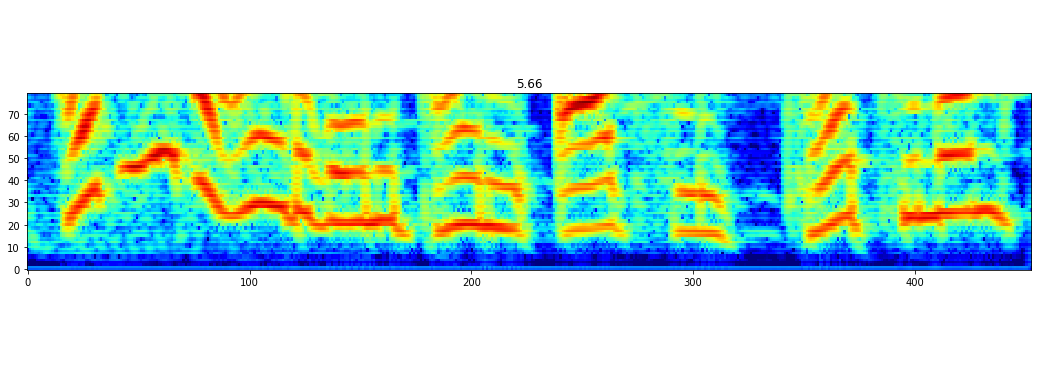

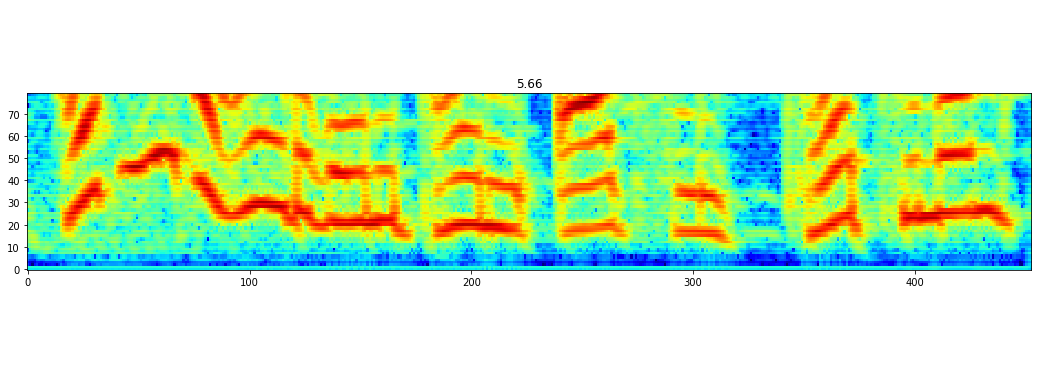

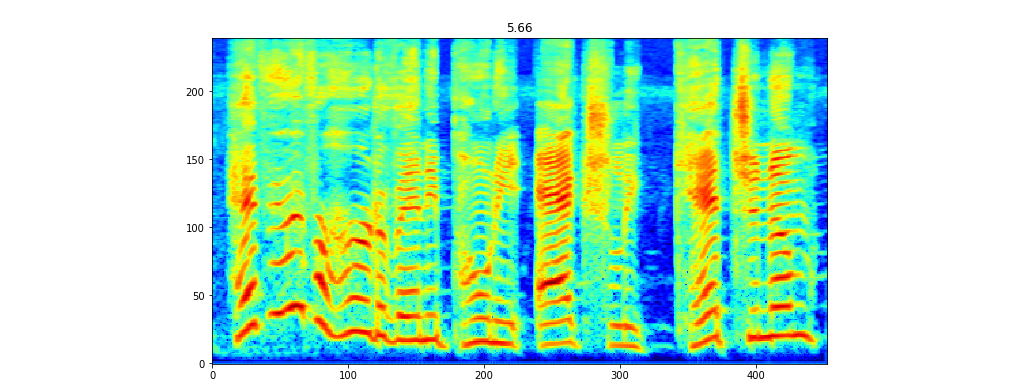

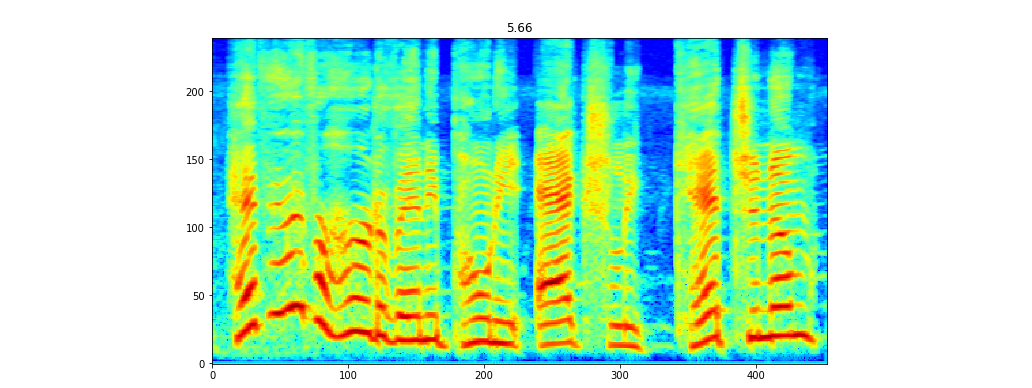

In [39]:
fpath = r"H:\TTCheckpoints\waveglow\outdir_EfficientSmallGlobalSpeakerEmbeddings\Testing2\samples\Ground Truth\00_16_56_Applejack_Neutral__have you ever heard of anypony actually catching him_.wav"

audio, sr = load_wav_to_torch(fpath) # load audio
audio = preempth(audio[None, None, ...]).squeeze() # preempth

audio_orig, sr = load_wav_to_torch(fpath) # load audio
#audio = preempth(audio[None, None, ...]).squeeze()

ipd.display(ipd.Audio(audio.numpy().squeeze(), rate=48000)) # diplay audio
ipd.display(ipd.Audio(audio_orig.numpy().squeeze(), rate=48000)) # display original audio

mel = load_mel(audio, stft)
disp_mel(mel)
mel = load_mel(audio_orig, stft)
disp_mel(mel)
mel = load_mel(audio, stft2)
disp_mel(mel)
mel = load_mel(audio_orig, stft2)
disp_mel(mel)

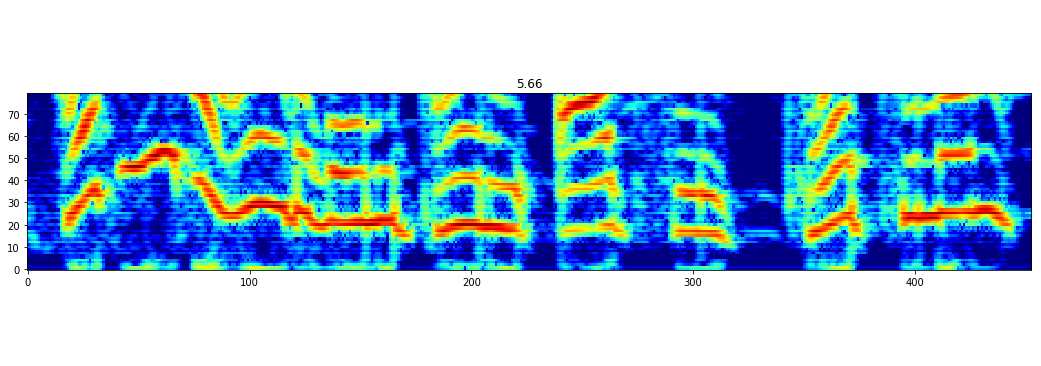

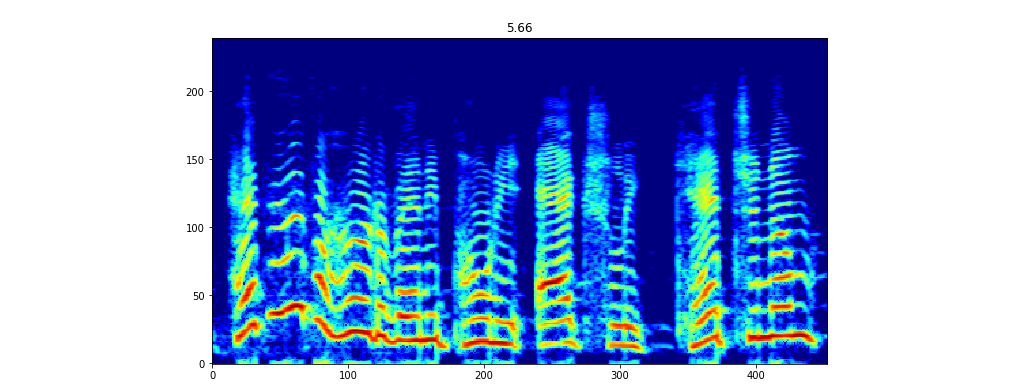

In [33]:
audio, sr = load_wav_to_torch(fpath)
with torch.no_grad():
    audio = audio/2**15
    audio = deempth(audio[None, None, ...]).squeeze()
    audio = audio*(2*15)
ipd.display(ipd.Audio(audio.numpy().squeeze(), rate=48000))
mel = load_mel(audio, stft)
disp_mel(mel)
mel = load_mel(audio, stft2)
disp_mel(mel)

# ------------

In [16]:
import os
import random
import json
import torch
import numpy as np
import IPython.display as ipd

from scipy.io.wavfile import read

from waveglow_utils import PreEmphasis, InversePreEmphasis

In [17]:
MAX_WAV_VALUE = 32768.0

In [18]:
from mel2samp import load_filepaths_and_text, load_wav_to_torch, get_mel_from_file

In [19]:
audio, sr = load_wav_to_torch(r"H:\TTCheckpoints\waveglow\outdir_EfficientLarge4\samples\Ground Truth\01_09_54_Sweetie Belle_Neutral__If sharing him is too hard, that might be the best thing.wav")
audio = audio/2**15
#audio = audio.cuda()
audio.max()

tensor(0.3742)

In [43]:
preempthasis_strength = 0.98
preempth = PreEmphasis(preempthasis_strength)
deempth = InversePreEmphasis(preempthasis_strength)


In [8]:
with torch.no_grad():
    print(audio.max())
    print(audio.min())
    ipd.display(ipd.Audio(preempth(audio[None, None, ...]).numpy().squeeze(), rate=48000))

tensor(0.3742)
tensor(-0.2628)


In [9]:
with torch.no_grad():
    de_audio = deempth(audio[None, None, ...])
    print(audio.max())
    print(audio.min())
    print(de_audio.max())
    print(de_audio.min())
    ipd.display(ipd.Audio(de_audio.numpy().squeeze(), rate=48000))

tensor(0.3742)
tensor(-0.2628)
tensor(0.7625)
tensor(-0.7203)


In [10]:
with torch.no_grad():
    re_audio = deempth(preempth(audio[None, None, ...]))
    print(audio.max())
    print(audio.min())
    print(re_audio.max())
    print(re_audio.min())
    ipd.display(ipd.Audio(re_audio.numpy().squeeze(), rate=48000))

tensor(0.3742)
tensor(-0.2628)
tensor(0.3428)
tensor(-0.2485)


In [11]:
%%timeit
deempth(audio[None, None, ...])

6.96 s ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
preempth(audio[None, None, ...])

8.79 ms ± 502 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
from scipy import signal

In [14]:
audio, sr = load_wav_to_torch(r"H:\TTCheckpoints\waveglow\outdir_EfficientLarge4\samples\Ground Truth\01_09_54_Sweetie Belle_Neutral__If sharing him is too hard, that might be the best thing.wav")
audio = audio/2**15
ipd.display(ipd.Audio(audio.squeeze(), rate=48000))
audio = preempth(audio[None, None, ...])
audio = audio.numpy()
#audio = np.append(audio[0], audio[1:] - preempthasis_strength * audio[:-1]) # preempthasis
audio = signal.lfilter([1], [1, -preempthasis_strength], audio) # de-preempthasis
ipd.display(ipd.Audio(audio.squeeze(), rate=48000))

In [15]:
%%timeit
signal.lfilter([1], [1, -preempthasis_strength], audio)

1.65 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%timeit
np.append(audio[0], audio[1:] - preempthasis_strength * audio[:-1])

442 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%%timeit
audio.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

# Reshape Columns in Tensor for potential use of groups=2 in Convs

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
x = torch.arange(8)[None, None, :]
print(x, x.shape, sep="\n")

tensor([[[0, 1, 2, 3, 4, 5, 6, 7]]])
torch.Size([1, 1, 8])


In [86]:
# 0, 1, 2, 3
# 3, 0, 1, 2
def permute_height(x, reverse=False, bipart=False, shift=False, inverse_shift=False):
    x = torch.split(x, 1, dim=2)
    if bipart and reverse:
        half = len(x)//2
        x = x[:half][::-1] + x[half:][::-1] # reverse H halfs [0,1,2,3,4,5,6,7] -> [3,2,1,0] + [7,6,5,4] -> [3,2,1,0,7,6,5,4]
    elif reverse:
        x = x[::-1] # reverse entire H [0,1,2,3,4,5,6,7] -> [7,6,5,4,3,2,1,0]
    if shift:
        x = (x[-1],) + x[:-1] # shift last H into first position [0,1,2,3,4,5,6,7] -> [7,0,1,2,3,4,5,6]
    if inverse_shift:
        x = x[1:] + (x[0],)   # shift first H into last position [0,1,2,3,4,5,6,7] -> [1,2,3,4,5,6,7,0]
    return torch.stack(x, dim=2).squeeze(-1)

In [99]:
torch.cat((x[:,:,x.shape[2]//4:], x[:,:,:x.shape[2]//4]), dim=2)

tensor([[[2, 3, 4, 5, 6, 7, 0, 1]]])